# How does the system behave under Node/CPU/Memory/Hardware/... errors and failures?

## Simulating memory error

In [1]:
from pyspark.sql import SparkSession
import requests
from io import BytesIO
import zipfile
from concurrent.futures import ThreadPoolExecutor
import tempfile
import os

# #Schritt 1: Spark-Session erstellen
# spark = SparkSession.builder \
#     .appName("AIS Data Processing") \
#     .getOrCreate()

spark = SparkSession.builder \
    .appName("AIS Data Processing") \
    .master("local[2]") \
    .config("spark.executor.memory", "512m") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()

# Schritt 2: Funktion zum Herunterladen, Entpacken und Speichern von CSV-Dateien
def download_and_unzip_to_temp_csv(url):
    response = requests.get(url)
    response.raise_for_status()
    zipfile_bytes = BytesIO(response.content)
    with zipfile.ZipFile(zipfile_bytes, 'r') as z:
        csv_filename = z.namelist()[0]  # Der Name der CSV-Datei im ZIP-Archiv
        with z.open(csv_filename) as csv_file:
            temp_file_path = os.path.join(tempfile.gettempdir(), csv_filename)
            with open(temp_file_path, "wb") as temp_file:
                temp_file.write(csv_file.read())
            return temp_file_path

# Schritt 3: Liste der ZIP-URLs
csv_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-03-01.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-02.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-03.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-04.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-05.zip"
]

# Schritt 4: Paralleles Herunterladen und Speichern der CSV-Dateien in temporären Pfaden
with ThreadPoolExecutor(max_workers=10) as executor:
    csv_file_paths = list(executor.map(download_and_unzip_to_temp_csv, csv_urls))

# Schritt 5: CSV-Dateien mit Spark einlesen und kombinieren
# Erstelle eine Liste von DataFrames für jede CSV-Datei
dataframes = [spark.read.csv(path, header=True, inferSchema=True) for path in csv_file_paths]

# Kombiniere alle DataFrames zu einem großen DataFrame
combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.union(df)

# Schritt 6: Einige Beispielzeilen ausgeben, um mögliche MMSI-Nummern anzuzeigen
combined_df.show(10)

+-------------------+--------------+---------+---------+---------+--------------------+----+----+-----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------+----+----------------+----+----+----+----+
|        # Timestamp|Type of mobile|     MMSI| Latitude|Longitude| Navigational status| ROT| SOG|  COG|Heading|    IMO|Callsign|Name|Ship type|Cargo type|Width|Length|Type of position fixing device|Draught|Destination| ETA|Data source type|   A|   B|   C|   D|
+-------------------+--------------+---------+---------+---------+--------------------+----+----+-----+-------+-------+--------+----+---------+----------+-----+------+------------------------------+-------+-----------+----+----------------+----+----+----+----+
|01/03/2024 00:00:00|       Class A|219000873| 56.99091|10.304543|Under way using e...|NULL| 0.0| 30.2|   NULL|Unknown| Unknown|NULL|Undefined|      NULL| NULL|  NULL|                     Undefined|   NULL|    Unknown

In [1]:
from pyspark.sql import SparkSession
import requests
from io import BytesIO
import zipfile
from concurrent.futures import ThreadPoolExecutor
import tempfile
import os

# #Schritt 1: Spark-Session erstellen
# spark = SparkSession.builder \
#     .appName("AIS Data Processing") \
#     .getOrCreate()

spark = SparkSession.builder \
    .appName("AIS Data Processing") \
    .master("local[2]") \
    .config("spark.executor.memory", "256m") \
    .config("spark.sql.shuffle.partitions", "2") \
    .getOrCreate()

# Schritt 2: Funktion zum Herunterladen, Entpacken und Speichern von CSV-Dateien
def download_and_unzip_to_temp_csv(url):
    response = requests.get(url)
    response.raise_for_status()
    zipfile_bytes = BytesIO(response.content)
    with zipfile.ZipFile(zipfile_bytes, 'r') as z:
        csv_filename = z.namelist()[0]  # Der Name der CSV-Datei im ZIP-Archiv
        with z.open(csv_filename) as csv_file:
            temp_file_path = os.path.join(tempfile.gettempdir(), csv_filename)
            with open(temp_file_path, "wb") as temp_file:
                temp_file.write(csv_file.read())
            return temp_file_path

# Schritt 3: Liste der ZIP-URLs
csv_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-03-01.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-02.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-03.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-04.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-05.zip"
]

# Schritt 4: Paralleles Herunterladen und Speichern der CSV-Dateien in temporären Pfaden
with ThreadPoolExecutor(max_workers=10) as executor:
    csv_file_paths = list(executor.map(download_and_unzip_to_temp_csv, csv_urls))

# Schritt 5: CSV-Dateien mit Spark einlesen und kombinieren
# Erstelle eine Liste von DataFrames für jede CSV-Datei
dataframes = [spark.read.csv(path, header=True, inferSchema=True) for path in csv_file_paths]

# Kombiniere alle DataFrames zu einem großen DataFrame
combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.union(df)

# Schritt 6: Einige Beispielzeilen ausgeben, um mögliche MMSI-Nummern anzuzeigen
combined_df.show(10)

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: org.apache.spark.SparkIllegalArgumentException: [INVALID_EXECUTOR_MEMORY] Executor memory 268435456 must be at least 471859200. Please increase executor memory using the --executor-memory option or "spark.executor.memory" in Spark configuration.
	at org.apache.spark.memory.UnifiedMemoryManager$.getMaxMemory(UnifiedMemoryManager.scala:230)
	at org.apache.spark.memory.UnifiedMemoryManager$.apply(UnifiedMemoryManager.scala:201)
	at org.apache.spark.SparkEnv$.create(SparkEnv.scala:320)
	at org.apache.spark.SparkEnv$.createDriverEnv(SparkEnv.scala:194)
	at org.apache.spark.SparkContext.createSparkEnv(SparkContext.scala:284)
	at org.apache.spark.SparkContext.<init>(SparkContext.scala:478)
	at org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(Unknown Source)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(Unknown Source)
	at java.lang.reflect.Constructor.newInstance(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)


if set memory too small, it can't work.

# What happens during network interruptions and partitioning?

## Simulating Download fail

In [2]:
from pyspark.sql import SparkSession
import requests
from io import BytesIO
import zipfile
from concurrent.futures import ThreadPoolExecutor
import tempfile
import os
import random

#Schritt 1: Spark-Session erstellen
spark = SparkSession.builder \
    .appName("AIS Data Processing") \
    .getOrCreate()

# # Schritt 2: Funktion zum Herunterladen, Entpacken und Speichern von CSV-Dateien
# def download_and_unzip_to_temp_csv(url):
#     response = requests.get(url)
#     response.raise_for_status()
#     zipfile_bytes = BytesIO(response.content)
#     with zipfile.ZipFile(zipfile_bytes, 'r') as z:
#         csv_filename = z.namelist()[0]  # Der Name der CSV-Datei im ZIP-Archiv
#         with z.open(csv_filename) as csv_file:
#             temp_file_path = os.path.join(tempfile.gettempdir(), csv_filename)
#             with open(temp_file_path, "wb") as temp_file:
#                 temp_file.write(csv_file.read())
#             return temp_file_path

def download_and_unzip_to_temp_csv(url):
    if random.random() < 0.3:  # 30% fail
        raise Exception(f"Simulated download failure for URL: {url}")
    response = requests.get(url)
    response.raise_for_status()
    zipfile_bytes = BytesIO(response.content)
    with zipfile.ZipFile(zipfile_bytes, 'r') as z:
        csv_filename = z.namelist()[0]
        with z.open(csv_filename) as csv_file:
            temp_file_path = os.path.join(tempfile.gettempdir(), csv_filename)
            with open(temp_file_path, "wb") as temp_file:
                temp_file.write(csv_file.read())
            return temp_file_path

# Schritt 3: Liste der ZIP-URLs
csv_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-03-01.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-02.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-03.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-04.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-05.zip"
]

# Schritt 4: Paralleles Herunterladen und Speichern der CSV-Dateien in temporären Pfaden
with ThreadPoolExecutor(max_workers=10) as executor:
    csv_file_paths = list(executor.map(download_and_unzip_to_temp_csv, csv_urls))

# Schritt 5: CSV-Dateien mit Spark einlesen und kombinieren
# Erstelle eine Liste von DataFrames für jede CSV-Datei
dataframes = [spark.read.csv(path, header=True, inferSchema=True) for path in csv_file_paths]

# Kombiniere alle DataFrames zu einem großen DataFrame
combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.union(df)

# Schritt 6: Einige Beispielzeilen ausgeben, um mögliche MMSI-Nummern anzuzeigen
combined_df.show(10)

Exception: Simulated download failure for URL: https://web.ais.dk/aisdata/aisdk-2024-03-02.zip

## Simulating Internet delay

In [ ]:
from pyspark.sql import SparkSession
import requests
from io import BytesIO
import zipfile
from concurrent.futures import ThreadPoolExecutor
import tempfile
import os
import random
import time

#Schritt 1: Spark-Session erstellen
spark = SparkSession.builder \
    .appName("AIS Data Processing") \
    .getOrCreate()

# # Schritt 2: Funktion zum Herunterladen, Entpacken und Speichern von CSV-Dateien
# def download_and_unzip_to_temp_csv(url):
#     response = requests.get(url)
#     response.raise_for_status()
#     zipfile_bytes = BytesIO(response.content)
#     with zipfile.ZipFile(zipfile_bytes, 'r') as z:
#         csv_filename = z.namelist()[0]  # Der Name der CSV-Datei im ZIP-Archiv
#         with z.open(csv_filename) as csv_file:
#             temp_file_path = os.path.join(tempfile.gettempdir(), csv_filename)
#             with open(temp_file_path, "wb") as temp_file:
#                 temp_file.write(csv_file.read())
#             return temp_file_path


def download_and_unzip_to_temp_csv(url):
    time.sleep(random.uniform(0, 5))  # random delay
    return download_and_unzip_to_temp_csv(url)
    response = requests.get(url)
    response.raise_for_status()
    zipfile_bytes = BytesIO(response.content)
    with zipfile.ZipFile(zipfile_bytes, 'r') as z:
        csv_filename = z.namelist()[0]  # Der Name der CSV-Datei im ZIP-Archiv
        with z.open(csv_filename) as csv_file:
            temp_file_path = os.path.join(tempfile.gettempdir(), csv_filename)
            with open(temp_file_path, "wb") as temp_file:
                temp_file.write(csv_file.read())
            return temp_file_path

# Schritt 3: Liste der ZIP-URLs
csv_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-03-01.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-02.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-03.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-04.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-05.zip"
]

# Schritt 4: Paralleles Herunterladen und Speichern der CSV-Dateien in temporären Pfaden
with ThreadPoolExecutor(max_workers=10) as executor:
    csv_file_paths = list(executor.map(download_and_unzip_to_temp_csv, csv_urls))

# Schritt 5: CSV-Dateien mit Spark einlesen und kombinieren
# Erstelle eine Liste von DataFrames für jede CSV-Datei
dataframes = [spark.read.csv(path, header=True, inferSchema=True) for path in csv_file_paths]

# Kombiniere alle DataFrames zu einem großen DataFrame
combined_df = dataframes[0]
for df in dataframes[1:]:
    combined_df = combined_df.union(df)

# Schritt 6: Einige Beispielzeilen ausgeben, um mögliche MMSI-Nummern anzuzeigen
combined_df.show(10)

WARN Executor: Issue communicating with driver in heartbeater
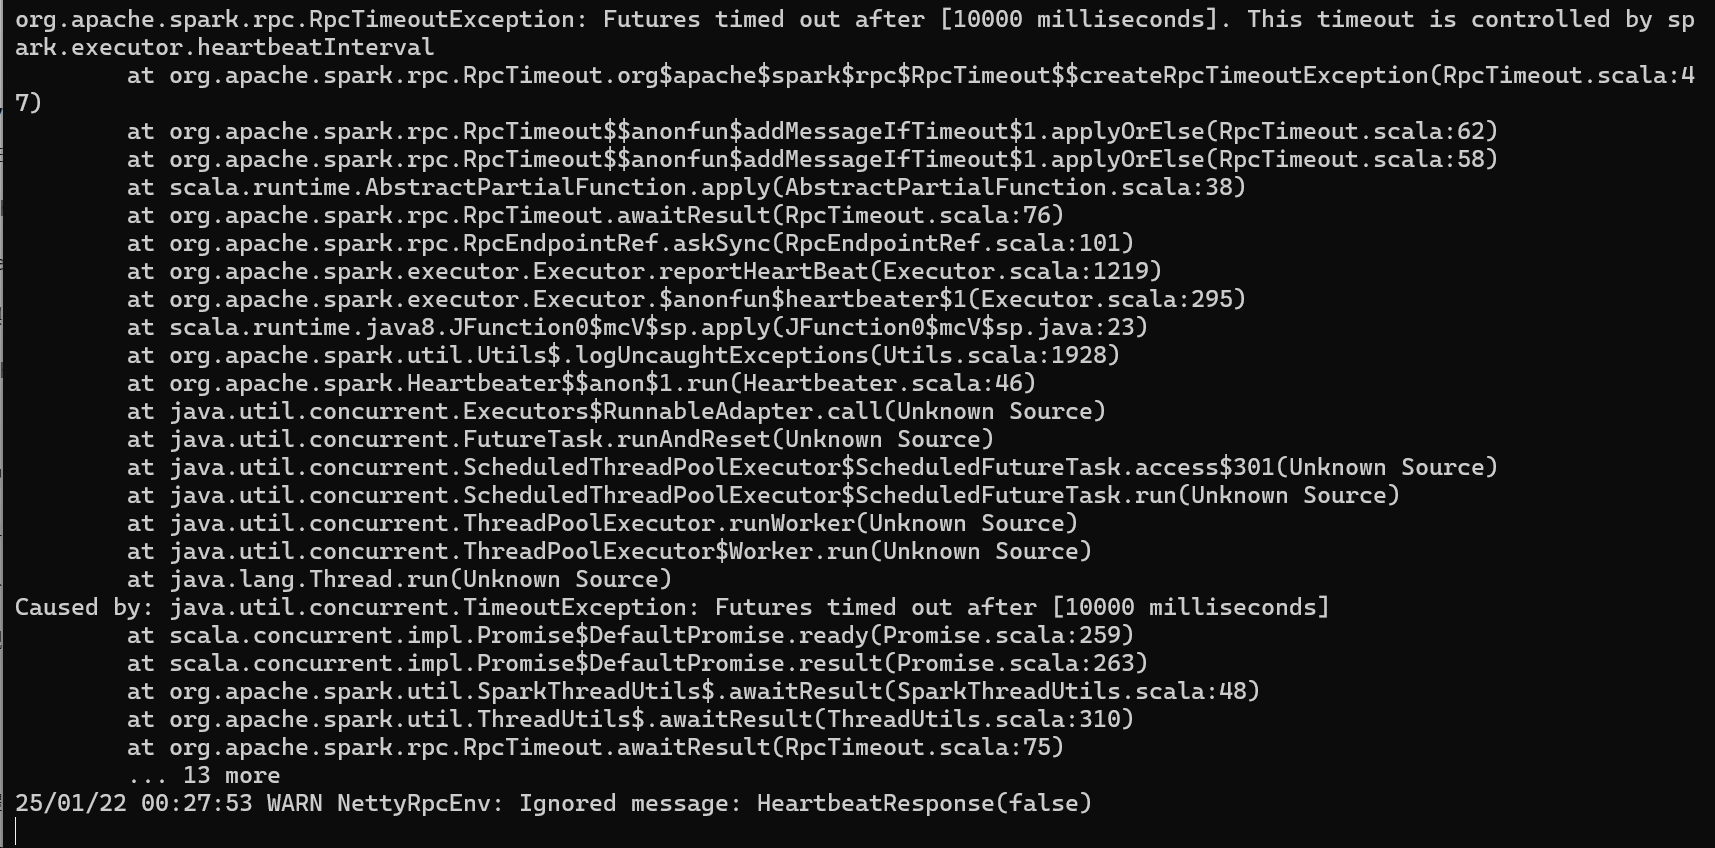

#  How do error handling mechanisms affect efficiency/scale/latency/throughput/... etc.? Are there any worst/best case considerations?

In [3]:
import time
import random
from pyspark.sql import SparkSession
import requests
from io import BytesIO
import zipfile
import os
import tempfile
from concurrent.futures import ThreadPoolExecutor, as_completed


spark = SparkSession.builder \
    .appName("AIS Fault Tolerance Test") \
    .master("local[2]") \
    .getOrCreate()


error_counts = {"total_attempts": 0, "success": 0, "failures": 0, "retries": 0}


timings = []


def download_and_unzip_with_metrics(url, max_retries=3):
    global error_counts
    for attempt in range(max_retries):
        error_counts["total_attempts"] += 1
        start_time = time.time()
        try:
            
            time.sleep(random.uniform(0, 2))  

            
            if random.random() < 0.2:
                raise Exception("Simulated network error!")

            
            response = requests.get(url)
            response.raise_for_status()
            zipfile_bytes = BytesIO(response.content)

            with zipfile.ZipFile(zipfile_bytes, 'r') as z:
                csv_filename = z.namelist()[0]
                with z.open(csv_filename) as csv_file:
                    temp_file_path = os.path.join(tempfile.gettempdir(), csv_filename)
                    with open(temp_file_path, "wb") as temp_file:
                        temp_file.write(csv_file.read())

            
            timings.append(time.time() - start_time)
            error_counts["success"] += 1
            return temp_file_path
        except Exception as e:
            error_counts["failures"] += 1
            if attempt < max_retries - 1:
                error_counts["retries"] += 1
                continue  # 重試
            print(f"Failed to download {url} after {max_retries} attempts: {e}")
            return None


csv_urls = [
    "https://web.ais.dk/aisdata/aisdk-2024-03-01.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-02.zip",
    "https://web.ais.dk/aisdata/aisdk-2024-03-03.zip"
]


start_time = time.time()
with ThreadPoolExecutor(max_workers=3) as executor:
    futures = {executor.submit(download_and_unzip_with_metrics, url): url for url in csv_urls}
    for future in as_completed(futures):
        result = future.result()

end_time = time.time()

print("\n===== Fault Tolerance Test Results =====")
print(f"Total Files Attempted: {error_counts['total_attempts']}")
print(f"Successful Downloads: {error_counts['success']}")
print(f"Failed Downloads: {error_counts['failures']}")
print(f"Retries: {error_counts['retries']}")
print(f"Average Download Time (success): {sum(timings)/len(timings):.2f} seconds" if timings else "No successful downloads")
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")


spark.stop()



===== Fault Tolerance Test Results =====
Total Files Attempted: 4
Successful Downloads: 3
Failed Downloads: 1
Retries: 1
Average Download Time (success): 277.91 seconds
Total Execution Time: 294.70 seconds
